In [1]:
import sys
import torch

seed = 42
#torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
torch.set_printoptions(precision=2, sci_mode=False)


import pandas as pd
import numpy as np
import ast
import copy

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.MOL.constants import DEFAULT_PPM, PPM, DEFAULT_MODES
from fiora.IO.LibraryLoader import LibraryLoader
from fiora.MOL.FragmentationTree import FragmentationTree 
import fiora.visualization.spectrum_visualizer as sv

from sklearn.metrics import r2_score
import scipy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print(f'Working with Python {sys.version}')


[10:52:18] WARNING: not removing hydrogen atom without neighbors
[10:52:18] WARNING: not removing hydrogen atom without neighbors
[10:52:18] WARNING: not removing hydrogen atom without neighbors


Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


In [2]:
from typing import Literal
lib: Literal["NIST", "MSDIAL", "NIST/MSDIAL", "MSnLib"] = "MSnLib" #"MSnLib"
print(f"Preparing {lib} library")

debug_mode = False # Default: False
if debug_mode:
    print("+++ This is a test run (debug mode) with a small subset of data points. Results are not representative. +++")

Preparing MSnLib library


In [3]:
# key map to read metadata from pandas DataFrame
metadata_key_map = {
                "name": "Name",
                "collision_energy":  "CE", 
                "instrument": "Instrument_type",
                "ionization": "Ionization",
                "precursor_mz": "PrecursorMZ",
                "precursor_mode": "Precursor_type",
                "retention_time": "RETENTIONTIME",
                "ccs": "CCS"
                }


#
# Load specified libraries and align metadata
#

def load_training_data():
    if ("NIST" in lib or "MSDIAL" in lib):
        data_path: str = f"{home}/data/metabolites/preprocessed/datasplits_Jan24.csv"
    elif lib == "MSnLib":
        data_path: str = f"{home}/data/metabolites/preprocessed/datasplits_msnlib_April25_v1.csv"
    else:
        raise NameError(f"Unknown library selected {lib=}.")
    L = LibraryLoader()
    df = L.load_from_csv(data_path)
    return df

df = load_training_data()

# Restore dictionary values
dict_columns = ["peaks", "summary"]
for col in dict_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x.replace('nan', 'None')))
    #df[col] = df[col].apply(ast.literal_eval)
    
df['group_id'] = df['group_id'].astype(int)


In [ ]:
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.CovariateFeatureEncoder import CovariateFeatureEncoder


CE_upper_limit = 100.0
weight_upper_limit = 1000.0


if debug_mode:
    df = df.iloc[:10000,:]
    #df = df.iloc[5000:20000,:]

overwrite_setup_features = None
if lib == "MSnLib":
    overwrite_setup_features = {
        "instrument": ["HCD"],
        "precursor_mode": ["[M+H]+", "[M-H]-", "[M]+", "[M]-"]
    
    }


df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
covariate_encoder = CovariateFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument", "element_composition"], sets_overwrite=overwrite_setup_features)
rt_encoder = CovariateFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument", "element_composition"], sets_overwrite=overwrite_setup_features)

covariate_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
covariate_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))
df.apply(lambda x: x["Metabolite"].set_id(x["group_id"]) , axis=1)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], covariate_encoder, rt_encoder), axis=1)
_ = df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)

In [ ]:
from fiora.MOL.MetaboliteIndex import MetaboliteIndex

mindex: MetaboliteIndex = MetaboliteIndex()
mindex.index_metabolites(df["Metabolite"])

In [ ]:
mindex.create_fragmentation_trees()
list_of_mismatched_ids = mindex.add_fragmentation_trees_to_metabolite_list(df["Metabolite"], graph_mismatch_policy="recompute")
print(f"Total number of recomputed trees: {len(list_of_mismatched_ids)}")

Total number of recomputed trees: 62


In [ ]:
#df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
_ = df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=x["ppm_peak_tolerance"]), axis=1)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Example data with more rare elements
# data = {
#     "Element": ["C", "H", "O", "N", "F", "Cl", "Br", "I", "P", "S", "Si"],
#     "Count": [100, 80, 60, 40, 20, 10, 5, 2, 3, 4, 1],
# }
# df = pd.DataFrame(data)

# # Create the main bar plot
# fig, ax_main = plt.subplots(figsize=(8, 6))
# sns.barplot(x="Element", y="Count", data=df, ax=ax_main, palette="Blues")
# ax_main.set_title("Element Distribution (Broad Overview)")
# ax_main.set_xlabel("Element")
# ax_main.set_ylabel("Count")

# # Create a zoomed-in bar plot for rare elements
# rare_elements = df[df["Count"] < 20]
# ax_zoom = fig.add_axes([0.7, 0.5, 0.4, 0.4])  # [x, y, width, height] in relative coordinates
# sns.barplot(x="Element", y="Count", data=rare_elements, ax=ax_zoom, palette="Reds")
# ax_zoom.set_title("Rare Elements")
# ax_zoom.set_xlabel("")
# ax_zoom.set_ylabel("")

# # Adjust the layout
# plt.tight_layout()
# plt.show()

In [ ]:
from fiora.MOL.MetaboliteDatasetStatistics import MetaboliteDatasetStatistics

ORDERED_ELEMENT_LIST = ["C", "H", "O", "N", "F", "Cl", "Br", "I", "P", "S", "Si"] # same as in constants.py, but different order
stats = MetaboliteDatasetStatistics(df)
stats.generate_molecular_statistics()

/tmp/ipykernel_421447/2447058246.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_421447/2447058246.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_421447/2447058246.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


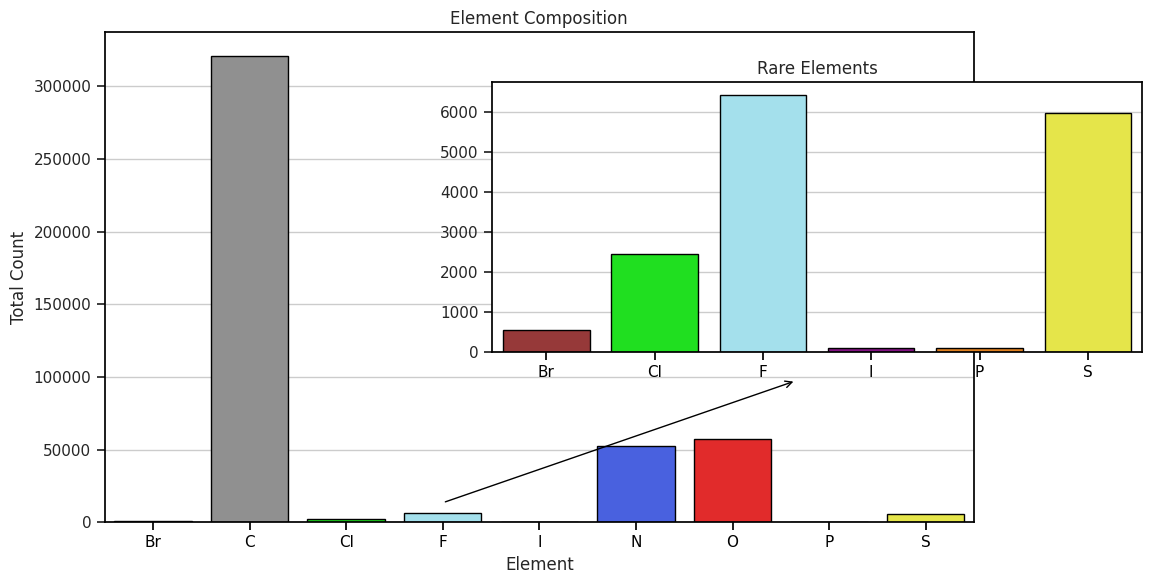

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from fiora.visualization.define_colors import ELEMENT_COLORS, set_light_theme  # Import the element colors

set_light_theme() 

# Extract total counts for plotting
total_counts = stats.get_statistics()['Molecular Summary']['Total Counts']

# Drop Hydrogen completely
filtered_counts = {element: count for element, count in total_counts.items() if element != "H"}

# Define rare elements (everything except C, O, N)
rare_elements = {element: count for element, count in filtered_counts.items() if element not in ["C", "O", "N"]}

# Create the main plot (all elements including rare ones)
fig, ax_main = plt.subplots(figsize=(10, 6))
sns.barplot(
    x=list(filtered_counts.keys()),
    y=list(filtered_counts.values()),
    ax=ax_main,
    palette=[ELEMENT_COLORS[element] for element in filtered_counts.keys()],
    edgecolor='black', 
)
ax_main.set_title("Element Composition")
ax_main.set_xlabel("Element")
ax_main.set_ylabel("Total Count")

# Create the zoomed-in plot for rare elements
ax_zoom_loc = [0.5, 0.4, 0.65, 0.45] # [x, y, width, height] in relative coordinates
ax_zoom = fig.add_axes(ax_zoom_loc)  
sns.barplot(
    x=list(rare_elements.keys()),
    y=list(rare_elements.values()),
    ax=ax_zoom,
    palette=[ELEMENT_COLORS[element] for element in rare_elements.keys()],
    edgecolor='black',
)
ax_zoom.set_title("Rare Elements")
ax_zoom.set_xlabel("")
ax_zoom.set_ylabel("")

# # Get the position of Fluorine (F) in the main plot
# f_index_main = list(filtered_counts.keys()).index("F")
# f_count_main = filtered_counts["F"]

# # Get the position of Fluorine (F) in the zoomed-in subplot
# f_index_zoom = list(rare_elements.keys()).index("F")
# f_count_zoom = rare_elements["F"]

# # Calculate the relative position of Fluorine (F) in the subplot
# subplot_x_start, subplot_y_start, subplot_width, subplot_height = ax_zoom_loc
# subplot_x_pos = subplot_x_start + (f_index_zoom / len(rare_elements)) * subplot_width
# subplot_y_pos = subplot_y_start + (f_count_zoom / max(rare_elements.values())) * subplot_height

# # Add an arrow from F in the main plot to F in the subplot
# ax_main.annotate(
#     "", 
#     xy=(subplot_x_pos, subplot_y_pos),  # Arrow end point in the subplot
#     xytext=(f_index_main, f_count_main + 10),  # Arrow start point in the main plot
#     arrowprops=dict(facecolor='black', edgecolor="black", arrowstyle="->"),
# )


# Get the position of Fluorine (F) in the main plot
f_index_main = list(filtered_counts.keys()).index("F")
f_count_main = filtered_counts["F"]

# Get the position of Fluorine (F) in the zoomed-in subplot
f_index_zoom = list(rare_elements.keys()).index("F")
f_count_zoom = rare_elements["F"]

# Calculate the relative position of Fluorine (F) in the subplot
subplot_x_start, subplot_y_start, subplot_width, subplot_height = ax_zoom_loc
subplot_x_pos = subplot_x_start + (f_index_zoom / len(rare_elements)) * subplot_width
subplot_y_pos = subplot_y_start 

# Convert subplot coordinates to global figure coordinates
subplot_x_pos, subplot_y_pos = ax_zoom.transAxes.transform((f_index_zoom / len(rare_elements) + 0.038, -0.15))  # Relative position in figure coordinates
subplot_x_pos, subplot_y_pos = ax_main.transData.inverted().transform((subplot_x_pos, subplot_y_pos))  # Convert to main plot's data coordinates

# Add an arrow from F in the main plot to F in the subplot
ax_main.annotate(
    "", 
    xy=(subplot_x_pos, subplot_y_pos),  # Arrow end point (Fluorine bar in subplot in global coordinates)
    xytext=(f_index_main, f_count_main + 7000),  # Arrow start point (Fluorine bar in main plot)
    arrowprops=dict(facecolor='black', edgecolor="black", arrowstyle="->"),
)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


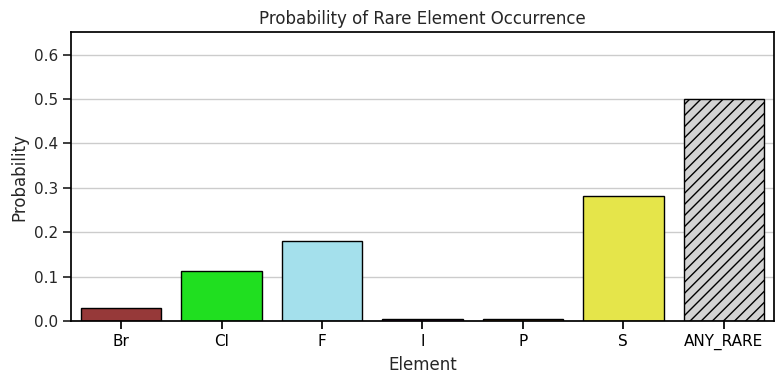

In [ ]:
# light gray html
ELEMENT_COLORS["ANY_RARE"] = "#D3D3D3"  # Light gray for ANY_RARE

# Extract presence probabilities for rare elements
presence_probabilities = stats.get_statistics()['Molecular Summary']['Presence Probabilities']
rare_element_probabilities = {element: prob for element, prob in presence_probabilities.items() if element not in ["C", "O", "N", "H"]}

# Create the probability plot
fig, ax_prob = plt.subplots(figsize=(8, 4))
bars = sns.barplot(
    x=list(rare_element_probabilities.keys()),
    y=list(rare_element_probabilities.values()),
    hue=list(rare_element_probabilities.keys()),
    ax=ax_prob,
    palette=[ELEMENT_COLORS[element] for element in rare_element_probabilities.keys()],
    edgecolor='black',
    legend=False
)

# Apply hatching manually for ANY_RARE
for bar, element in zip(bars.patches, rare_element_probabilities.keys()):
    if element == "ANY_RARE":
        bar.set_hatch("///")  # Apply hatching for ANY_RARE


ax_prob.set_title("Probability of Rare Element Occurrence")
ax_prob.set_ylim(0, 0.65)  # Set y-axis limits to [0, 1] for probabilities
ax_prob.set_xlabel("Element")
ax_prob.set_ylabel("Probability")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

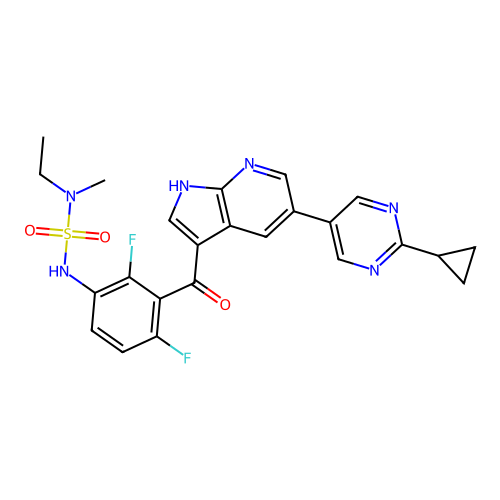

In [ ]:

# Find a large molecule with S in the structure
large_molecule_with_s = df[df['Metabolite'].apply(lambda x: 'S' in x.node_elements and x.ExactMolWeight > 500)].iloc[0]
very_large_molecule_with_s = df[df['Metabolite'].apply(lambda x: 'S' in x.node_elements and x.ExactMolWeight > 900)].iloc[2]

large_molecule_with_s["Metabolite"].draw(high_res=True)


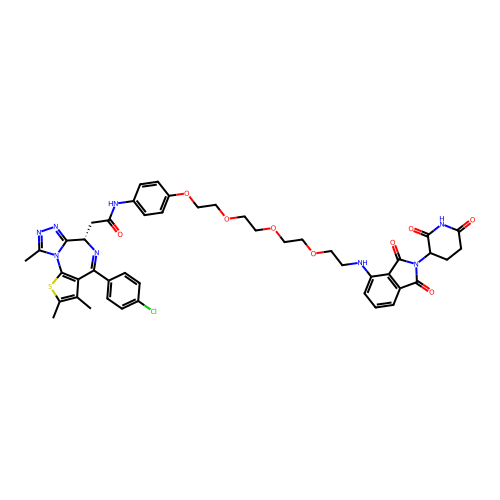

In [ ]:
very_large_molecule_with_s["Metabolite"].draw(high_res=True)

In [ ]:
import torch_geometric as geom

if torch.cuda.is_available(): 
    torch.cuda.empty_cache()
    dev = "cuda:0"
else: 
    dev = "cpu"
    
print(f"Running on device: {dev}")

Running on device: cpu


In [ ]:

MODEL_PATH = f"{home}/data/metabolites/pretrained_models/v0.1.1_OS_depth12_June25.pt"
OLD_MODEL_PATH = f"{home}/data/metabolites/pretrained_models/v0.1.1_OS_depth5_June25_ls1.pt"

from fiora.GNN.FioraModel import FioraModel
from fiora.MS.SimulationFramework import SimulationFramework


try:
    model = FioraModel.load_from_state_dict(MODEL_PATH)
    old_model = FioraModel.load_from_state_dict(OLD_MODEL_PATH)
except:
    raise NameError("Error: Failed loading from state dict.")

In [ ]:
model.eval()
model = model.to(dev)

fiora: SimulationFramework = SimulationFramework(None, dev=dev)
model.model_params

{'param_tag': 'default',
 'gnn_type': 'RGCNConv',
 'depth': 12,
 'hidden_dimension': 300,
 'residual_connections': False,
 'layer_stacking': True,
 'embedding_aggregation': 'concat',
 'embedding_dimension': 300,
 'dense_layers': 2,
 'dense_dim': 1000,
 'input_dropout': 0.2,
 'latent_dropout': 0.2,
 'node_feature_layout': {'symbol': 10, 'num_hydrogen': 5, 'ring_type': 5},
 'edge_feature_layout': {'bond_type': 4, 'ring_type': 5},
 'static_feature_dimension': 18,
 'static_rt_feature_dimension': 17,
 'output_dimension': 10,
 'atom_features': ['bond_type', 'ring_type'],
 'setup_features': ['collision_energy',
  'molecular_weight',
  'precursor_mode',
  'instrument',
  'element_composition'],
 'setup_features_categorical_set': {'instrument': ['HCD'],
  'precursor_mode': ['[M+H]+', '[M-H]-', '[M]+', '[M]-']},
 'rt_features': ['molecular_weight',
  'precursor_mode',
  'instrument',
  'element_composition'],
 'prepare_additional_layers': False,
 'rt_supported': False,
 'ccs_supported': False,
 

In [ ]:
from fiora.visualization.spectrum_visualizer import plot_spectrum


large_stats = fiora.simulate_and_score(large_molecule_with_s["Metabolite"], model, query_peaks=large_molecule_with_s["peaks"])
print(f"Cosine large (new model): {large_stats["spectral_sqrt_cosine"]} and {large_stats["spectral_sqrt_cosine_wo_prec"]}")
plot_spectrum(large_molecule_with_s, {"peaks": large_stats["sim_peaks"]}, highlight_matches=True)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (80x8108 and 8118x1000)

In [ ]:
copy_large_molecule_with_s = copy.deepcopy(large_molecule_with_s)

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
covariate_encoder = CovariateFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"], sets_overwrite=overwrite_setup_features)
rt_encoder = CovariateFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"], sets_overwrite=overwrite_setup_features)

covariate_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
covariate_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

copy_large_molecule_with_s["Metabolite"].compute_graph_attributes(node_encoder, bond_encoder)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
copy_large_molecule_with_s["Metabolite"].add_metadata(copy_large_molecule_with_s["summary"], covariate_encoder, rt_encoder)
#_ = df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)


large_stats_old = fiora.simulate_and_score(copy_large_molecule_with_s["Metabolite"], old_model, query_peaks=copy_large_molecule_with_s["peaks"])


<Axes: xlabel='m/z', ylabel='Intensity'>

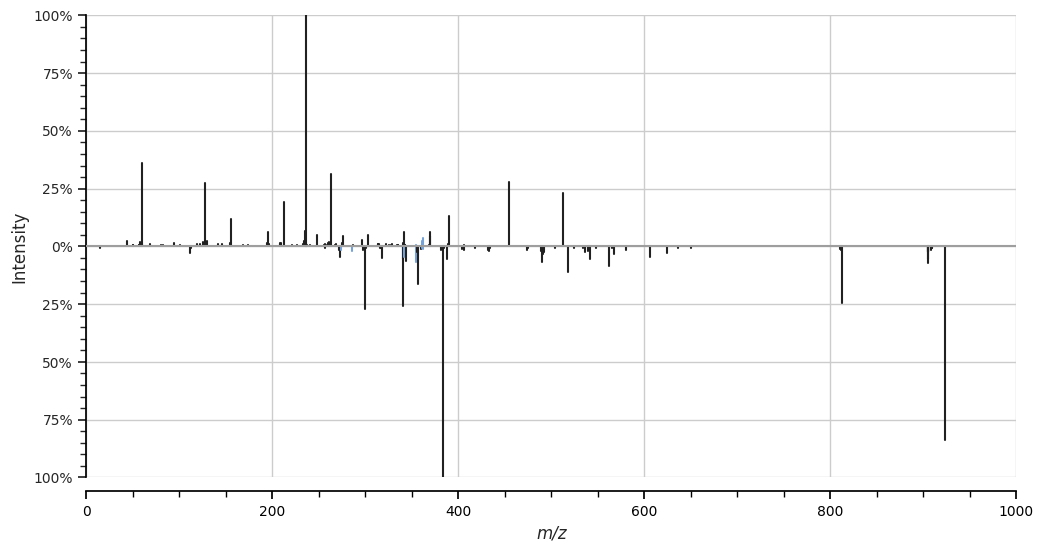

In [ ]:
plot_spectrum(copy_large_molecule_with_s, {"peaks": large_stats_old["sim_peaks"]}, highlight_matches=True)


In [ ]:
very_large_stats = fiora.simulate_and_score(very_large_molecule_with_s["Metabolite"], model, query_peaks=very_large_molecule_with_s["peaks"])
plot_spectrum(very_large_molecule_with_s, {"peaks": very_large_stats["sim_peaks"]}, highlight_matches=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (144x8108 and 8118x1000)

<Axes: xlabel='m/z', ylabel='Intensity'>

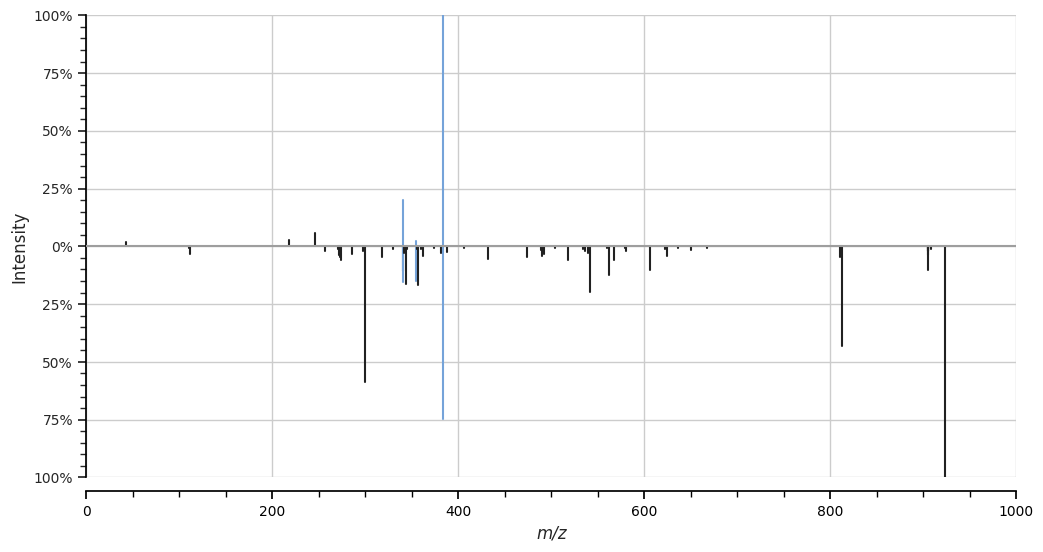

In [ ]:

copy_very_large_molecule_with_s = copy.deepcopy(very_large_molecule_with_s)

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
covariate_encoder = CovariateFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"], sets_overwrite=overwrite_setup_features)
rt_encoder = CovariateFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"], sets_overwrite=overwrite_setup_features)

covariate_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
covariate_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 

copy_very_large_molecule_with_s["Metabolite"].compute_graph_attributes(node_encoder, bond_encoder)

#df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
copy_very_large_molecule_with_s["Metabolite"].add_metadata(copy_very_large_molecule_with_s["summary"], covariate_encoder, rt_encoder)
#_ = df.apply(lambda x: x["Metabolite"].set_loss_weight(x["loss_weight"]), axis=1)


very_large_stats_old = fiora.simulate_and_score(copy_very_large_molecule_with_s["Metabolite"], old_model, query_peaks=copy_very_large_molecule_with_s["peaks"])
plot_spectrum(copy_very_large_molecule_with_s, {"peaks": very_large_stats_old["sim_peaks"]}, highlight_matches=True)

